# Comparison of Integration Methods 
## For the Mechanical Chaotic Oscillator
```
Michael Huster
Duquesne University
profhuster@gmail.com
2019-07-07
```

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
%matplotlib inline

In [2]:
# From https://pundit.pratt.duke.edu/wiki/Python:Ordinary_Differential_Equations/Examples
def state_plotter(times, states, fig_num):
    num_states = np.shape(states)[0]
    num_cols = int(np.ceil(np.sqrt(num_states)))
    num_rows = int(np.ceil(num_states / num_cols))
    plt.figure(fig_num, figsize=(12,6))
    plt.clf()
    fig, ax = plt.subplots(num_rows, num_cols, num=fig_num, clear=True,
                         squeeze=False)
    for n in range(num_states):
        row = n // num_cols
        col = n % num_cols
        ax[row][col].plot(times, states[n], 'b,')
        ax[row][col].set(xlabel='Time',
                         ylabel='$y_{:0.0f}(t)$'.format(n),
                         title='$y_{:0.0f}(t)$ vs. Time'.format(n))
        
    for n in range(num_states, num_rows * num_cols):
        fig.delaxes(ax[n // num_cols][n % num_cols])

    fig.tight_layout()
    return fig

# MCO - Mechanical Chaotic Oscillator
## Numerical Integration

The Newton's Second Law equation of motion are

$$
\omega_{\phi} = \dot{\phi}
$$

and

$$
\dot{\omega}_{\phi} = -\frac{\mu}{I}\left [ B_{field} \sin \phi + 
B_{drive} \cos \phi \sin \omega_d t \right ] - \frac{\beta 
\omega_{\phi}}{I}
$$

I define $\omega_0^2 = \frac{\mu B_{field}}{I}$, $b = \frac{B_{drive}}{B_{field}}$ and 
$\gamma = \frac{\beta}{I}$,
then the equation of the MCO can be written

$$
\dot{\omega}_{\phi} = -\omega_0^2 \left [
\sin \phi + b \cos \phi \sin \omega_d t \right ] 
- \gamma \omega_{\phi}
$$

# Global Integration Parameters

In [268]:
N_CYCLES = 101
POINTS_PER_CYCLE = 5

PHI0 = 0.01 * np.pi

# Globals
OMEGA_0 = 1.0
OMEGA_0_SQ = OMEGA_0**2
b = 0.0
OMEGA_D = 0.741 * OMEGA_0
GAMMA = 0.000

T_DRIVE = 2.0 * np.pi / OMEGA_D
DT = T_DRIVE / POINTS_PER_CYCLE
DT2 = DT * DT
nPoints = int(N_CYCLES * POINTS_PER_CYCLE)

print("DT = {} s".format(DT))
print("Integrating {} cycles = {} points".format(N_CYCLES, nPoints))

DT = 1.6958664796706036 s
Integrating 101 cycles = 505 points


# Velocity Verlet Integration

In [130]:
def velocityVerlet(i, y, t):
    accHalfHalf = -0.5 * OMEGA_0_SQ * (np.sin(y[0,i]) + b * np.cos(y[0,i]) * np.sin(OMEGA_D * t[i])) - GAMMA * y[1,i]
    y[0,i+1] = y[0,i] + y[1,i] * DT + accHalfHalf * DT2
    accFullHalf = -0.5 * OMEGA_0_SQ * (np.sin(y[0,i+1]) + b * np.cos(y[0,i+1]) * np.sin(OMEGA_D * t[i+1])) - \
      GAMMA * y[1,i]
    y[1,i+1] = y[1,i] + (accHalfHalf + accFullHalf) * DT

CPU times: user 649 ms, sys: 99 ms, total: 748 ms
Wall time: 361 ms


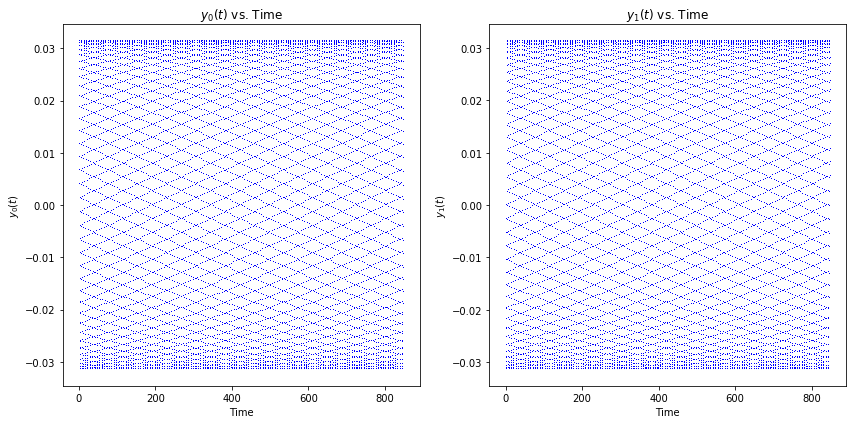

In [257]:
%%time
# Initialize
t = np.arange(0, nPoints * DT, DT)
yinit = np.array([PHI0, 0.0])
y = np.zeros((2,nPoints), dtype='float64')
y[0,0] = yinit[0]
y[0,1] = yinit[1]

# Run
for i in range(nPoints-1):
    velocityVerlet(i, y, t)
# Plot
fig = state_plotter(t, y, 1)
fig.savefig("MCO_Int_VV1.png")

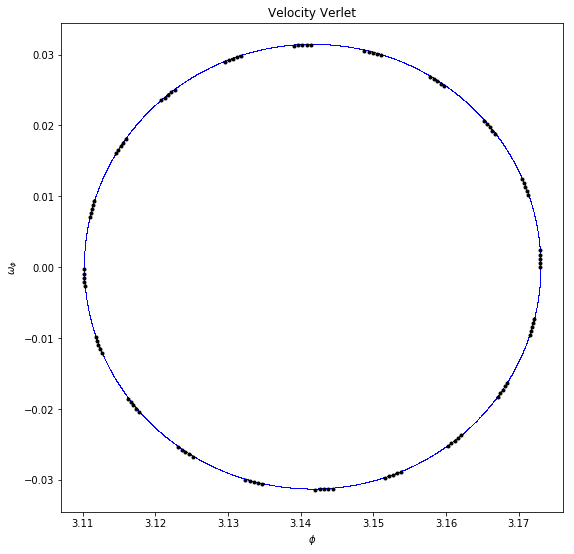

In [258]:
fig = plt.figure(figsize=(9,9))
ax = fig.add_subplot(111)
ax.plot((y[0]+np.pi)%(2*np.pi), y[1], 'b,')
ax.plot((y[0,0:nPoints:POINTS_PER_CYCLE]+np.pi)%(2*np.pi), y[1,0:nPoints:POINTS_PER_CYCLE], 'k.')
ax.set_xlabel('$\phi$')
ax.set_ylabel('$\omega_{\phi}$')
ax.set_title("Velocity Verlet")
fig.savefig("MCO_Int_VV2.png")

# Euler-Cromer (Symplectic Euler)

In [259]:
def symEuler(i, y, t):
    # Update p
    y[1,i+1] = (y[1,i] - DT * OMEGA_0_SQ * (np.sin(y[0,i]) + b * np.cos(y[0,i]) * np.sin(OMEGA_D * t[i]))) / \
        (1.0 + GAMMA * DT)
    y[0,i+1] = y[0,i] + DT * y[1,i+1]

CPU times: user 461 ms, sys: 84.8 ms, total: 545 ms
Wall time: 209 ms


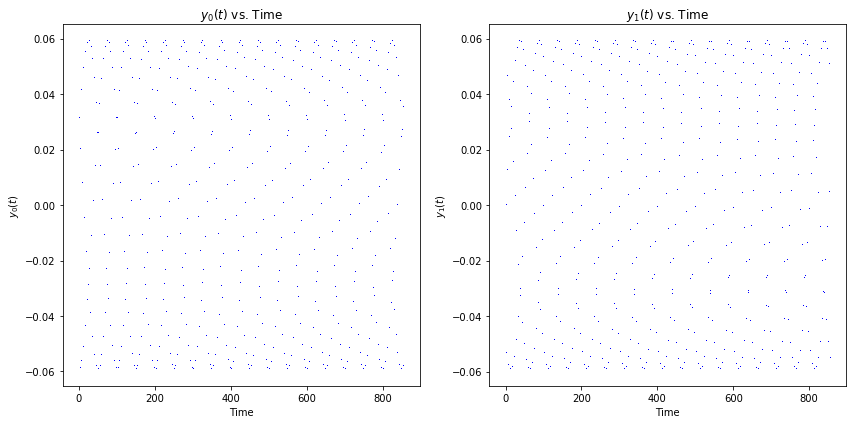

In [269]:
%%time
# Initialize
t = np.arange(0, nPoints * DT, DT)
yinit = np.array([PHI0, 0.0])
y = np.zeros((2,nPoints), dtype='float64')
y[0,0] = yinit[0]
y[0,1] = yinit[1]

# Run
for i in range(nPoints-1):
    symEuler(i, y, t)
# Plot
fig = state_plotter(t, y, 1)
fig.savefig("MCO_Int_SymEu1.png")

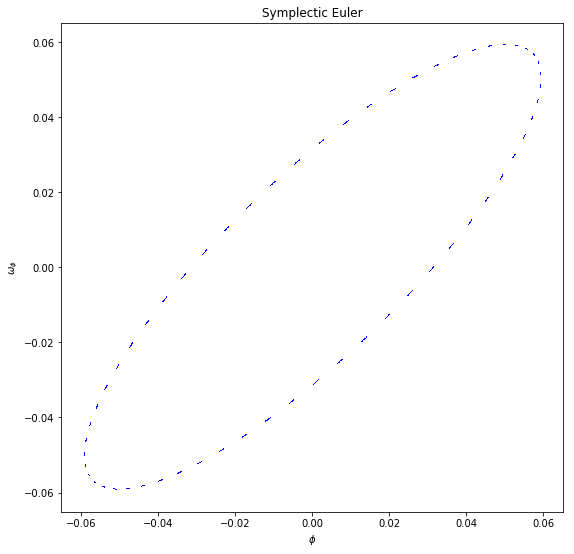

In [270]:
fig = plt.figure(figsize=(9,9))
ax = fig.add_subplot(111)
ax.plot(y[0], y[1], 'b,')
ax.set_xlabel('$\phi$')
ax.set_ylabel('$\omega_{\phi}$')
ax.set_title("Symplectic Euler")
fig.savefig("MCO_Int_SymEu2.png")

# Define ODE Derivative Function

In [91]:
# %% Define derivative function

def f(t, y):
    # t = time
    # y[0] = phi
    # y[1] = omega
    global OMEGA_0_SQ, b, OMEGA_D, GAMMA
    phiDot = y[1]
    omegaDot = -OMEGA_0_SQ * (np.sin(y[0]) + b * np.cos(y[0]) * np.sin(OMEGA_D * t)) - GAMMA * phiDot
    return np.array((phiDot, omegaDot))

# Initialize, Run, and Plot
## (Using the Default RK45 Method)

CPU times: user 25.7 s, sys: 382 ms, total: 26.1 s
Wall time: 25.2 s


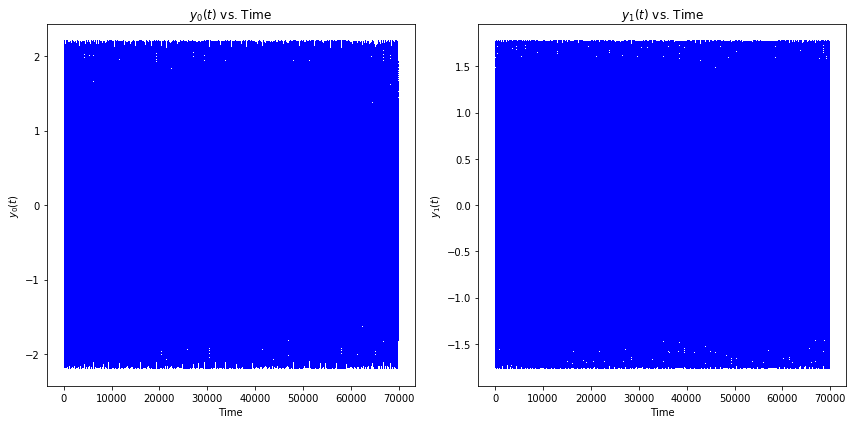

In [133]:
%%time
# Initialize
R_TOL = 1e-4
A_TOL = 1e-7
t = np.arange(0, nPoints * DT, DT)
yinit = np.array([PHI0, 0.0])

# Run
sol = solve_ivp(lambda t, y: f(t, y), 
                [t[0], t[-1]], yinit, t_eval=t, method='RK45', rtol=R_TOL, atol=A_TOL)

# Plot
fig = state_plotter(sol.t, sol.y, 1)
fig.savefig("MCO_Int_RK1.png")

CPU times: user 533 ms, sys: 76.3 ms, total: 609 ms
Wall time: 371 ms


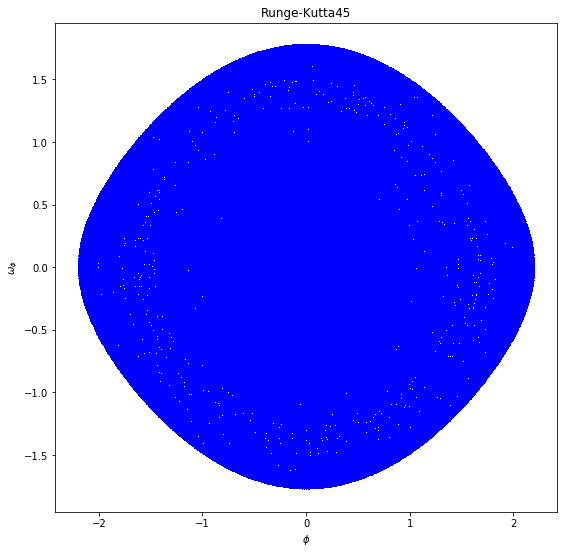

In [134]:
%%time
fig = plt.figure(figsize=(9,9))
ax = fig.add_subplot(111)
ax.plot(sol.y[0], sol.y[1], 'b,')
ax.set_xlabel('$\phi$')
ax.set_ylabel('$\omega_{\phi}$')
ax.set_title("Runge-Kutta45")
fig.savefig("MCO_Int_RK2.png")

# Initialize, Run, and Plot
## (Using the Radau Method)

CPU times: user 13.4 s, sys: 139 ms, total: 13.5 s
Wall time: 13.1 s


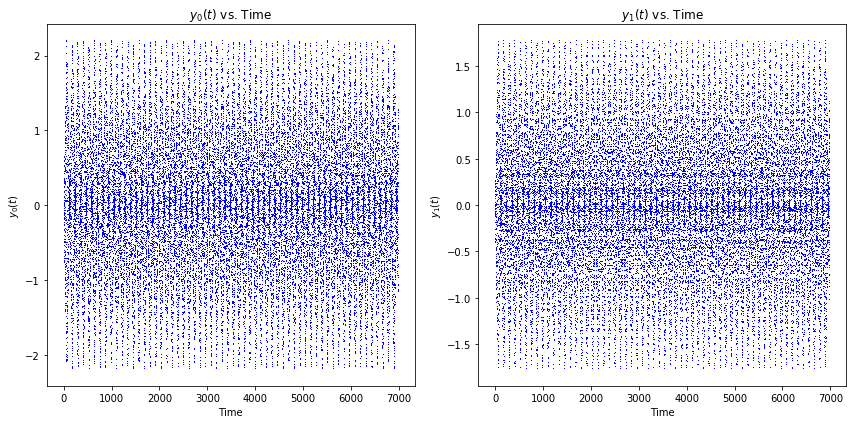

In [119]:
%%time
# Initialize
t = np.arange(0, nPoints * DT, DT)
yinit = np.array([PHI0, 0.0])

# Run
sol = solve_ivp(lambda t, y: f(t, y), 
                [t[0], t[-1]], yinit, t_eval=t, method='Radau', rtol=R_TOL, atol=A_TOL)

# Plot
fig = state_plotter(sol.t, sol.y, 1)
fig.savefig("MCO_Int_Radau1.png")

CPU times: user 446 ms, sys: 76 ms, total: 522 ms
Wall time: 281 ms


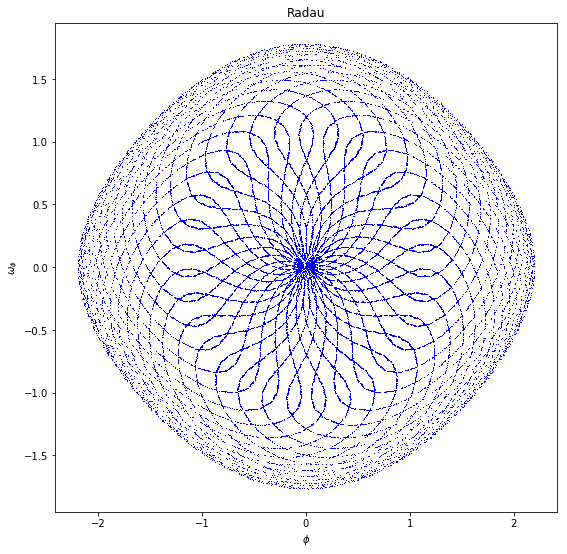

In [120]:
%%time
fig = plt.figure(figsize=(9,9))
ax = fig.add_subplot(111)
ax.plot(sol.y[0], sol.y[1], 'b,')
ax.set_xlabel('$\phi$')
ax.set_ylabel('$\omega_{\phi}$')
ax.set_title("Radau")
fig.savefig("MCO_Int_Radau2.png")

In [31]:
nPoints/64.0

1562.5